## imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import random

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

TensorFlow 1.x selected.


In [0]:
sess = tf.Session()
keras.backend.set_session(sess)

## Classifier Training utilities

In [0]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model(n_classes):
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes))
    # model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [0]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [0]:
def train_model(train_images, train_labels, test_images, test_labels, softmax_temp=1, 
                batch_size=128, maxepoches=12, learning_rate=0.1, lr_decay=1e-6, lr_drop=20):
    
    n_classes = train_labels.shape[1]
    
    # lr scheduler 
    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    model = build_mnist_model(n_classes)

    # compile model with loss which applies temp softmax before cross entropy 
    model.compile(loss=lambda y_true, y_pred: tf.nn.softmax_cross_entropy_with_logits(logits=y_pred/softmax_temp, labels=y_true),
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])
    
    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr])
    return model

### Defensive distillation

In [0]:
def train_distillation(train_images, train_labels, test_images, test_labels, temp, add_softmax=True):
    # train teacher
    print(f"training Teacher model with Temp {temp}")
    teacher = train_model(train_images, train_labels, test_images, test_labels, temp)

    # get student labels
    train_logits = teacher.predict(train_images)
    test_logits = teacher.predict(test_images)

    with tf.Session() as sess:
        student_train_labels = sess.run(tf.nn.softmax(train_logits/temp))
        student_test_labels = sess.run(tf.nn.softmax(test_logits/temp))

    # train student and add regular softmax (temp=1)
    print(f"training Student model with Temp {temp}")
    student = train_model(train_images, student_train_labels, test_images, student_test_labels, temp)
    if add_softmax:
        student.add(layers.Activation('softmax', name='y_pred'))

    return student

### Train models

In [99]:
# Load and prepare the datasets for training
binary = True
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels_), (test_images, test_labels_) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels_, num_classes)
test_labels = keras.utils.to_categorical(test_labels_, num_classes)

if binary:
    wanted_classes = random.sample(range(num_classes), 2)
    print('selected classes for binary data:', wanted_classes)
    train_mask = (train_labels_ == wanted_classes[0]) | (train_labels_ == wanted_classes[1]) 
    test_mask = (test_labels_ == wanted_classes[0]) | (test_labels_ == wanted_classes[1])
    # get only wanted samples
    train_labels, train_images, test_labels, test_images = train_labels[train_mask], train_images[train_mask], test_labels[test_mask], test_images[test_mask]
    # get only wanted columns
    train_labels, test_labels = train_labels[:, wanted_classes], test_labels[:, wanted_classes]
    assert((train_labels.sum(axis=1) == 1).all)
    assert((test_labels.sum(axis=1) == 1).all)

selected classes for binary data: [2, 7]


In [100]:
# regular CNN classifier
regular_model = train_model(train_images, train_labels, test_images, test_labels, softmax_temp=1)
regular_model.add(layers.Activation('softmax', name='y_pred'))

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 8s 645us/sample - loss: 0.3861 - categorical_accuracy: 0.8932 - val_loss: 0.0899 - val_categorical_accuracy: 0.9684
Epoch 2/12
12223/12223 [==============================] - 7s 555us/sample - loss: 0.0762 - categorical_accuracy: 0.9735 - val_loss: 0.0749 - val_categorical_accuracy: 0.9748
Epoch 3/12
12223/12223 [==============================] - 7s 554us/sample - loss: 0.0607 - categorical_accuracy: 0.9798 - val_loss: 0.0699 - val_categorical_accuracy: 0.9748
Epoch 4/12
12223/12223 [==============================] - 7s 557us/sample - loss: 0.0554 - categorical_accuracy: 0.9812 - val_loss: 0.0675 - val_categorical_accuracy: 0.9772
Epoch 5/12
12223/12223 [==============================] - 7s 557us/sample - loss: 0.0515 - categorical_accuracy: 0.9812 - val_loss: 0.0653 - val_categorical_accuracy: 0.9772
Epoch 6/12
12223/12223 [==============================] - 7s 556us/sample - loss:

In [113]:
# train classifier with defensive distilation
student = train_distillation(train_images, train_labels, test_images, test_labels, temp=20)

training Teacher model with Temp 20
Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 8s 667us/sample - loss: 0.6766 - categorical_accuracy: 0.7878 - val_loss: 0.6332 - val_categorical_accuracy: 0.9447
Epoch 2/12
12223/12223 [==============================] - 7s 572us/sample - loss: 0.3703 - categorical_accuracy: 0.9456 - val_loss: 0.1256 - val_categorical_accuracy: 0.9607
Epoch 3/12
12223/12223 [==============================] - 7s 563us/sample - loss: 0.1060 - categorical_accuracy: 0.9646 - val_loss: 0.0908 - val_categorical_accuracy: 0.9670
Epoch 4/12
12223/12223 [==============================] - 7s 564us/sample - loss: 0.0802 - categorical_accuracy: 0.9734 - val_loss: 0.0877 - val_categorical_accuracy: 0.9689
Epoch 5/12
12223/12223 [==============================] - 7s 559us/sample - loss: 0.0721 - categorical_accuracy: 0.9732 - val_loss: 0.0786 - val_categorical_accuracy: 0.9748
Epoch 6/12
12223/12223 [=====================

## attacks

contstants

In [0]:
model = student  # change to student for defensive distilation

In [0]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

--- TF Only FGSM Implementation ---

In [0]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def TF_FastGradientSignMethod(model, images, labels, epsilon):
    adv_loss = keras.losses.categorical_crossentropy(labels, model(images))
    adv_grads = tf.gradients(adv_loss, images)[0]
    adv_out = images + epsilon * tf.math.sign(adv_grads)
    return adv_out

In [0]:
images = tf.Variable(test_images)
attack_labels = tf.Variable(test_labels)
adv_out = TF_FastGradientSignMethod(model, images, attack_labels, epsilon=10.0)

Test loss: 0.68
Successfully moved out of source class: 0.15
Mean perturbation distance: 1.44


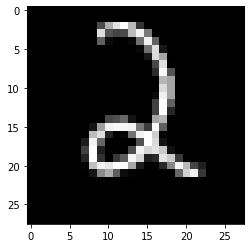

In [130]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:test_labels
                                         })
TestAttack(model, adv_images, test_images, test_labels)

--- TF Only TGSM Implementation ---

In [0]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TF_TargetedGradientSignMethod(model, images, target, epsilon):
    adv_loss = keras.losses.categorical_crossentropy(target, model(images))
    adv_grads = tf.gradients(adv_loss, images)[0]
    adv_out = images - epsilon * tf.math.sign(adv_grads)
    return adv_out

In [0]:
if binary:
  target = 1 - test_labels
else:
  target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
  target = keras.utils.to_categorical(target, num_classes)
images = tf.Variable(test_images)
attack_labels = tf.Variable(target)
adv_out = TF_TargetedGradientSignMethod(model, images, attack_labels, epsilon=0.3)

Test loss: 0.71
Successfully moved out of source class: 0.78
Test loss: 0.68
Successfully perturbed to target class: 0.78
Mean perturbation distance: 0.29


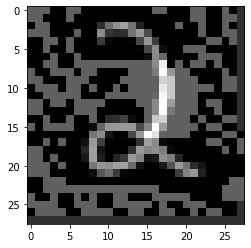

In [121]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:target
                                         })
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

--- TF Only BIM Implementation ---

In [0]:
def TF_BasicIterativeMethod(model, images, labels, epsilon, iter_eps, iterations=10, targeted=False):
    
    adv_out = tf.identity(images)
    targeted_tensor = tf.constant(targeted)
    
    def cond(images, adv_out):
        return True
    
    def perturb(images, adv_out):
        
        # Perturb with FGSM or TGSM
        def tgsm_base():
            return TF_TargetedGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
    
        def fgsm_base():
            return TF_FastGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
        adv_out = tf.cond(targeted_tensor, tgsm_base, fgsm_base)     
        
        # Project the perturbation to the epsilon ball
        perturbation = adv_out - images
        norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = tf.sqrt(tf.maximum(10e-12, norm))
        factor = tf.minimum(1.0, tf.divide(epsilon, norm))
        adv_out = tf.clip_by_value(images + perturbation * factor, 0.0, 1.0)
        
        return images, adv_out
        
    _,adv_out = tf.while_loop(cond, perturb, (images, adv_out), back_prop=True, maximum_iterations=iterations)
    
    return adv_out

In [0]:
if binary:
  target = 1 - test_labels
else:
  target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
  target = keras.utils.to_categorical(target, num_classes)
images = tf.Variable(test_images)
attack_labels = tf.Variable(target)
adv_out = TF_BasicIterativeMethod(model, images, attack_labels, iterations=20, epsilon=6.0, iter_eps=0.07, targeted=True)

Test loss: 0.71
Successfully moved out of source class: 0.83
Test loss: 0.68
Successfully perturbed to target class: 0.83
Mean perturbation distance: 0.19


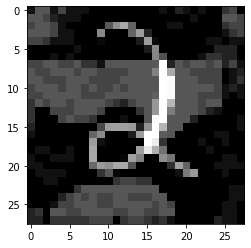

In [124]:
adv_images = sess.run(adv_out, feed_dict={images:test_images, 
                                          attack_labels:target
                                         })
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

## plot logit plots

In [132]:
# regular CNN classifier
regular_model = train_model(train_images, train_labels, test_images, test_labels, softmax_temp=1)

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 8s 683us/sample - loss: 0.3130 - categorical_accuracy: 0.8946 - val_loss: 0.1004 - val_categorical_accuracy: 0.9641
Epoch 2/12
12223/12223 [==============================] - 7s 579us/sample - loss: 0.0885 - categorical_accuracy: 0.9695 - val_loss: 0.0826 - val_categorical_accuracy: 0.9733
Epoch 3/12
12223/12223 [==============================] - 7s 576us/sample - loss: 0.0700 - categorical_accuracy: 0.9769 - val_loss: 0.0733 - val_categorical_accuracy: 0.9757
Epoch 4/12
12223/12223 [==============================] - 7s 566us/sample - loss: 0.0613 - categorical_accuracy: 0.9780 - val_loss: 0.0671 - val_categorical_accuracy: 0.9777
Epoch 5/12
12223/12223 [==============================] - 7s 564us/sample - loss: 0.0550 - categorical_accuracy: 0.9806 - val_loss: 0.0649 - val_categorical_accuracy: 0.9772
Epoch 6/12
12223/12223 [==============================] - 7s 566us/sample - loss:

In [145]:
# train classifier with defensive distilation
student = train_distillation(train_images, train_labels, test_images, test_labels, temp=20, add_softmax=False)

training Teacher model with Temp 20
Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 9s 697us/sample - loss: 0.6647 - categorical_accuracy: 0.8101 - val_loss: 0.5822 - val_categorical_accuracy: 0.9481
Epoch 2/12
12223/12223 [==============================] - 7s 574us/sample - loss: 0.2956 - categorical_accuracy: 0.9494 - val_loss: 0.1168 - val_categorical_accuracy: 0.9602
Epoch 3/12
12223/12223 [==============================] - 7s 582us/sample - loss: 0.1003 - categorical_accuracy: 0.9685 - val_loss: 0.0919 - val_categorical_accuracy: 0.9680
Epoch 4/12
12223/12223 [==============================] - 7s 575us/sample - loss: 0.0837 - categorical_accuracy: 0.9705 - val_loss: 0.0844 - val_categorical_accuracy: 0.9718
Epoch 5/12
12223/12223 [==============================] - 10s 781us/sample - loss: 0.0733 - categorical_accuracy: 0.9750 - val_loss: 0.0806 - val_categorical_accuracy: 0.9743
Epoch 6/12
12223/12223 [====================

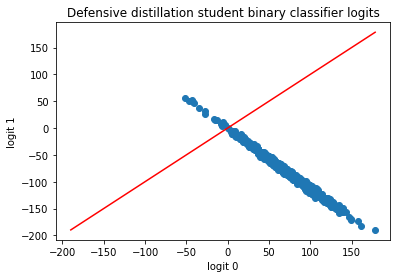

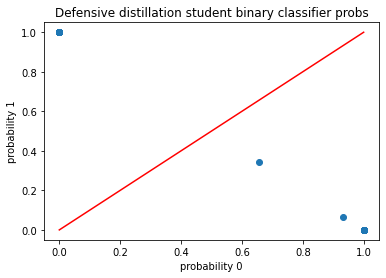

In [146]:
model = student
model_name = "Defensive distillation student"
softmax_temp = 1

# get data for one class only
one_class_test_images = test_images[test_labels[:,0]==1]

# calculate logits
logits = model.predict(one_class_test_images)

plt.scatter(logits[:, 0], logits[:, 1])
plt.plot([logits.min(), logits.max()], [logits.min(), logits.max()], color='r')
plt.title(f"{model_name} binary classifier logits")
plt.xlabel("logit 0")
plt.ylabel("logit 1")
plt.show()

# calculate probs
with tf.Session() as sess:
    probs = sess.run(tf.nn.softmax(logits/softmax_temp))
plt.scatter(probs[:, 0], probs[:, 1])
plt.plot([probs.min(), probs.max()], [probs.min(), probs.max()], color='r')
plt.title(f"{model_name} binary classifier probs")
plt.xlabel("probability 0")
plt.ylabel("probability 1")
plt.show()